# 구내식당 식사인원 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 사용자 운영체제 확인
import os
os.name

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# Dataset

In [3]:
train = pd.read_csv("./data/weather_corona_train.csv", encoding='cp949')
test = pd.read_csv("./data/weather_corona_test.csv", encoding='cp949')

train = train.iloc[:,1:]
test = test.iloc[:,1:]

In [4]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,평균기온(°C),일강수량(mm),평균 지면온도(°C),확진자수
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,-0.6,NaN,2.3,0
1,2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,-2.3,NaN,1.2,0
2,2016-02-03,수,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,-1.7,NaN,1.3,0
3,2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,-0.2,NaN,1.0,0
4,2016-02-05,금,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,1.3,NaN,2.4,0


# 전처리 및 EDA

## EDA

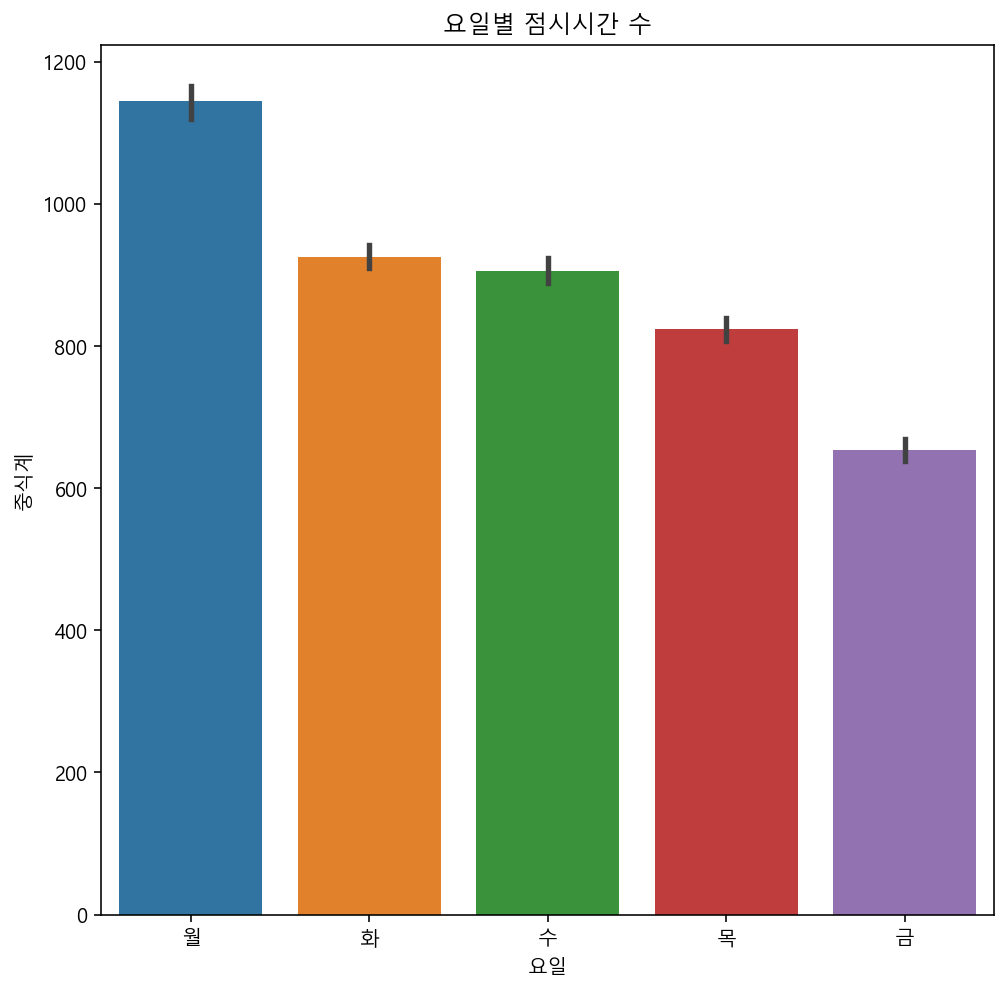

In [5]:
plt.figure(figsize=(8,8))


sns.barplot(x="요일", y="중식계", data=train)
plt.title("요일별 점시시간 수")
plt.show()

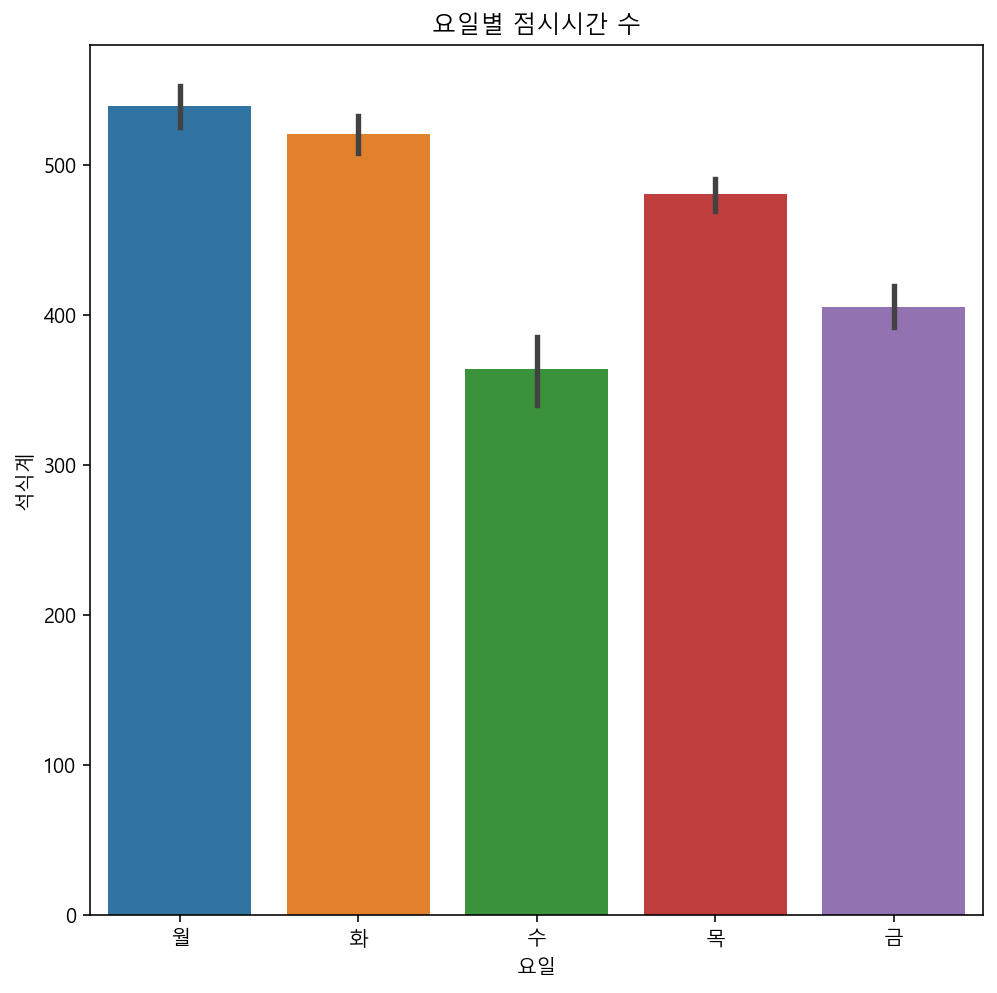

In [6]:
plt.figure(figsize=(8,8))


sns.barplot(x="요일", y="석식계", data=train)
plt.title("요일별 점시시간 수")
plt.show()

## 인원

In [7]:
train['식사가능자수'] = train['본사정원수'] - train['본사출장자수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사출장자수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

# train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
# test['휴가비율'] = test['본사휴가자수']/test['본사정원수']

# train['출장비율'] = train['본사출장자수']/train['본사정원수']
# test['출장비율'] = test['본사출장자수']/test['본사정원수']

train['야근비율'] = train['본사시간외근무명령서승인건수']/train['식사가능자수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['식사가능자수']

# train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']
# test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

# 식사가능자수로 나눌까? 아니면 본사정원수로 나눌까?
train['중식계비율'] = train['중식계'] / train['식사가능자수']
train['석식계비율'] = train['석식계'] / train['식사가능자수']

## 날씨

In [8]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '평균기온(°C)',
       '일강수량(mm)', '평균 지면온도(°C)', '확진자수', '식사가능자수', '야근비율', '중식계비율', '석식계비율'],
      dtype='object')

In [9]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,평균기온(°C),일강수량(mm),평균 지면온도(°C),확진자수,식사가능자수,야근비율,중식계비율,석식계비율
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,-0.6,NaN,2.3,0,2401,0.099125,0.432736,0.137859
1,2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,-2.3,NaN,1.2,0,2378,0.134146,0.364592,0.235492
2,2016-02-03,수,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,-1.7,NaN,1.3,0,2365,0.046934,0.430021,0.242283
3,2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,-0.2,NaN,1.0,0,2277,0.155907,0.429513,0.230567
4,2016-02-05,금,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,1.3,NaN,2.4,0,2142,0.015873,0.431839,0.154062


In [10]:
train.drop(['평균 지면온도(°C)'], axis=1, inplace=True)
test.drop(['평균 지면온도(°C)'], axis=1, inplace=True)

### Null

In [11]:
print('train\n', train.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum(), '\n')
print('test\n', test.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum())

train
 평균기온(°C)      1
일강수량(mm)    819
dtype: int64 

test
 평균기온(°C)     0
일강수량(mm)    38
dtype: int64


In [12]:
train['평균기온(°C)'].fillna(method='ffill', inplace=True)

In [13]:
train['일강수량(mm)'].fillna(0, inplace=True)
test['일강수량(mm)'].fillna(0, inplace=True)

In [14]:
print('train\n', train.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum(), '\n')
print('test\n', test.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum())

train
 평균기온(°C)    0
일강수량(mm)    0
dtype: int64 

test
 평균기온(°C)    0
일강수량(mm)    0
dtype: int64


### 강수량

In [15]:
train['일강수량(mm)'] = np.where(train.loc[:,'일강수량(mm)']==0, 0, 1)

In [16]:
train['일강수량(mm)'].value_counts()

0    896
1    309
Name: 일강수량(mm), dtype: int64

### 기온
- test가 21.01.27 ~ 21.04.09 까지임

In [17]:
train.loc[:,['평균기온(°C)', '중식계', '석식계']].corr()

,평균기온(°C),중식계,석식계
평균기온(°C),1.000000,-0.094672,0.008495
중식계,-0.094672,1.000000,0.508287
석식계,0.008495,0.508287,1.000000


In [18]:
train.loc[:,['평균기온(°C)', '중식계비율', '석식계비율']].corr()

,평균기온(°C),중식계비율,석식계비율
평균기온(°C),1.000000,-0.060378,0.041280
중식계비율,-0.060378,1.000000,0.485553
석식계비율,0.041280,0.485553,1.000000


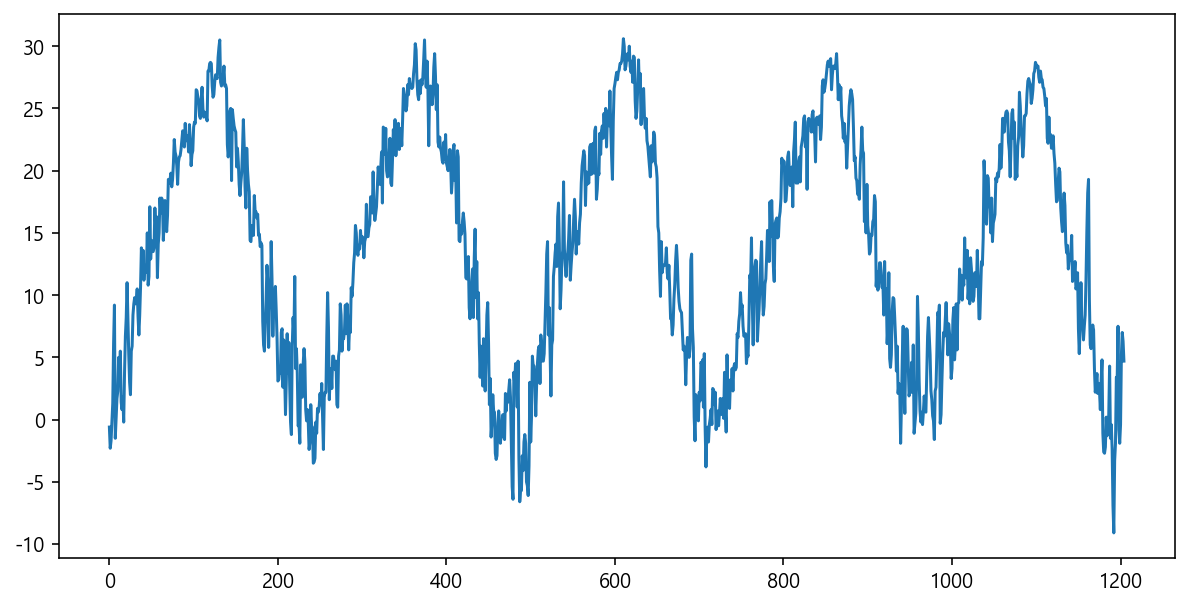

In [19]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train['평균기온(°C)'])
plt.show()

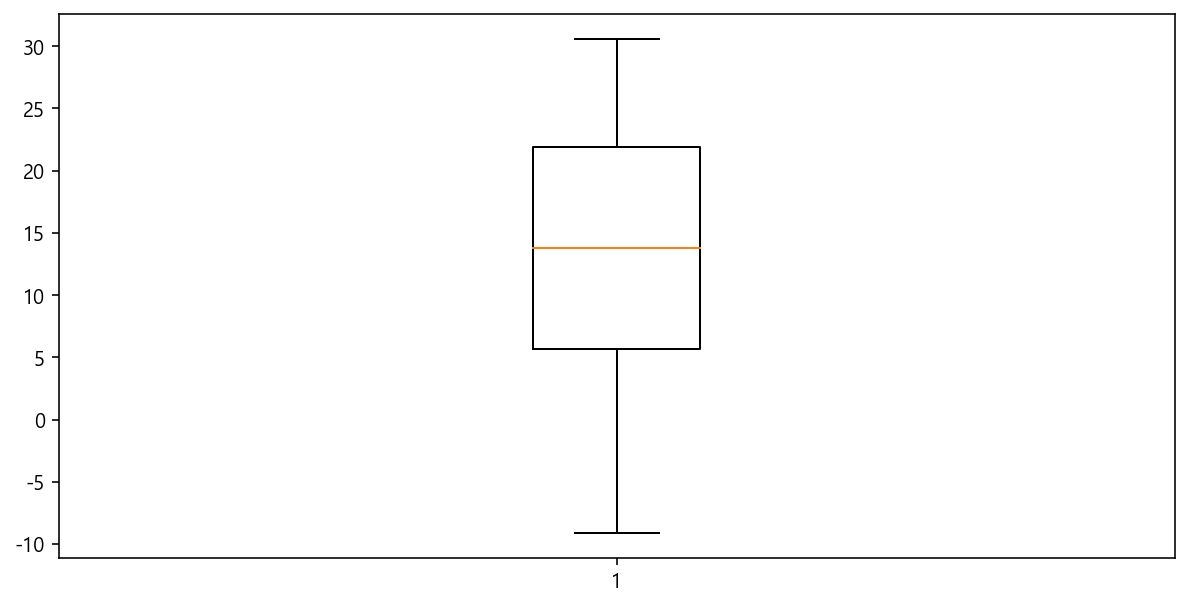

In [20]:
plt.figure(figsize=(10,5))
plt.boxplot(train['평균기온(°C)'])
plt.show()

In [21]:
train['평균기온(°C)'].describe()

count    1205.000000
mean       13.679585
std         9.326654
min        -9.100000
25%         5.700000
50%        13.800000
75%        21.900000
max        30.600000
Name: 평균기온(°C), dtype: float64

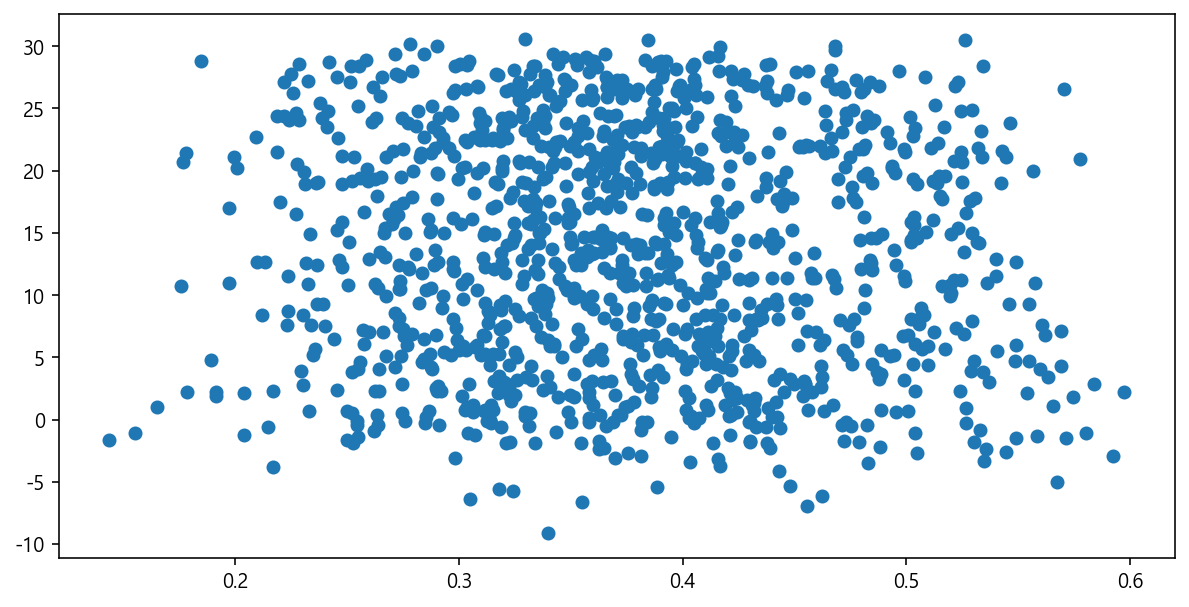

In [22]:
plt.figure(figsize=(10,5))
plt.scatter(x='중식계비율', y='평균기온(°C)', data=train)
plt.show()

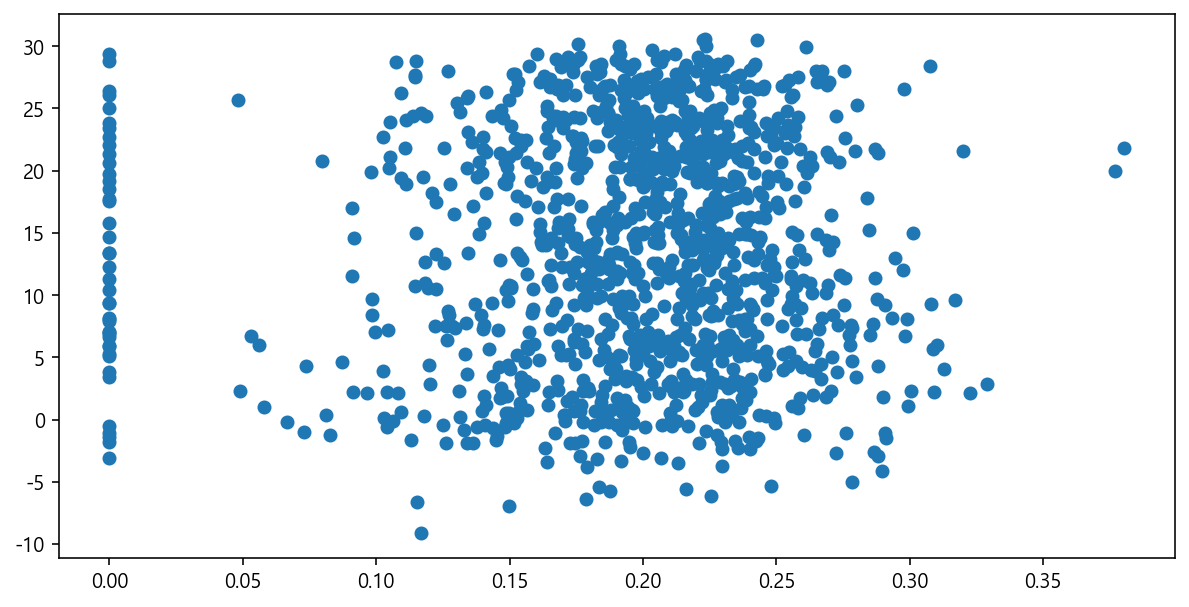

In [23]:
plt.figure(figsize=(10,5))
plt.scatter(x='석식계비율', y='평균기온(°C)', data=train)
plt.show()

In [24]:
# 얘내 둘은 왜 이렇게 높은겨
train[train['석식계비율'] >= 0.33]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,평균기온(°C),일강수량(mm),확진자수,식사가능자수,야근비율,중식계비율,석식계비율
163,2016-10-04,화,2670,59,239,1035,0,모닝롤/후르츠팬케익 우유/주스 구운계란 견과류죽/쌀밥 (쌀:국내산) 북어채국 김...,쌀밥/잡곡밥 (쌀:국내산) 배추된장국 버섯불고기 (쇠고기:호주산) 골뱅이소면무침 ...,쌀밥/잡곡밥 (쌀:국내산) 콩비지찌개 (돼지고기:국내산) 닭볶음 (닭고기:국내산) ...,1262,902,21.8,1,0,2372,0.436341,0.532040,0.380270
164,2016-10-05,수,2670,41,228,0,0,모닝롤/참치샌드 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 어묵국 감자...,쌀밥/잡곡밥 (쌀:국내산) 차돌박이찌개 (쇠고기:호주산) 매운주꾸미볶음 모둠소세지...,"쌀밥/잡곡밥 (쌀:국내산) 순두부찌개 미니함박조림 (쇠고기:호주산,돈육:국내산) ...",1336,905,20.0,1,0,2401,0.000000,0.556435,0.376926


## 확진자수

In [25]:
train['확진자수'].isnull().sum()

0

In [26]:
test['확진자수'].isnull().sum()

0

## 휴일 & 공휴일 전 후

In [27]:
holiday_list = [] 
for i in range(2016,2022):
    for date in holidays.KR(years=i).keys():  # 한국 공휴일 가져오기
        holiday_list.append(date)

In [28]:
holiday_before_list=[]
for_mat='%Y-%m-%d'
for i in holiday_list:
    holiday_before_list.append((i - timedelta(days=1)).strftime(for_mat))
        # i - timedelta(days=1): datetime에서 날짜 하루 빼기
        # .strftime(for_mat): 포맷과 같은 형식으로 datetime에서 str로 변환

In [29]:
def holiday_before(x):
    if x in holiday_before_list:
        return 1
    else:
        return 0
train['공휴일전'] = train.일자.apply(holiday_before)
test['공휴일전'] = test.일자.apply(holiday_before)

In [30]:
holiday_after_list=[]
for_mat='%Y-%m-%d'
for i in holiday_list:
    holiday_after_list.append((i + timedelta(days=1)).strftime(for_mat))

In [31]:
def holiday_after(x):
    if x in holiday_after_list:
        return 1
    else:
        return 0
train['공휴일후'] = train.일자.apply(holiday_after)
test['공휴일후'] = test.일자.apply(holiday_after)

In [32]:
## 누락된 것은 찾아서 넣음

# 16-4-13 국회의원 선거
train['공휴일전'][47]=1
train['공휴일후'][48]=1

# 17-5-9 대통령 선거
train['공휴일전'][311]=1
train['공휴일후'][312]=1

# 18-6-13 지방선거
train['공휴일전'][579]=1
train['공휴일후'][580]=1

# 20-4-15 국회의원 선거
train['공휴일전'][1027]=1
train['공휴일후'][1028]=1

# 20-9-30 추석
train['공휴일전'][1129]=1

In [33]:
train.공휴일전.value_counts()

0    1164
1      41
Name: 공휴일전, dtype: int64

In [34]:
train.공휴일후.value_counts()

0    1160
1      45
Name: 공휴일후, dtype: int64

In [35]:
train.loc[:,['공휴일전', '공휴일후']].sum()

공휴일전    41
공휴일후    45
dtype: int64

In [36]:
test.loc[:,['공휴일전', '공휴일후']].sum()

공휴일전    1
공휴일후    1
dtype: int64

## 일자

In [37]:
train.일자 = train.일자.astype('datetime64')
test.일자 = test.일자.astype('datetime64')

In [38]:
train['월'] = train.일자.dt.month
train['일'] = train.일자.dt.day
train['년'] = train.일자.dt.year

test['월'] = test.일자.dt.month
test['일'] = test.일자.dt.day
test['년'] = test.일자.dt.year

In [39]:
train.loc[train.중식계==0,['일자','요일','석식메뉴']]
# 중식 = 0 인 날 없음

,일자,요일,석식메뉴


In [40]:
train.loc[train.석식계==0,['일자','요일','석식메뉴']]
# 마지막주(4주차도 있고 5주차도 있는거보면 애매) 수요일
# 17-9-29: 추석 전 금요일
# 18-2-14: 설날 전 수요일
# 18-9-19: 다음주 수요일이 추석이라서 마지막주 수요일이긴 함
# 19-12-31: 마지막주 수요일이 성탄절, 다음날이 설날이라서 이때 안하는듯

,일자,요일,석식메뉴
204,2016-11-30,수,*
224,2016-12-28,수,*
244,2017-01-25,수,*
262,2017-02-22,수,*
281,2017-03-22,수,*
306,2017-04-26,수,*
327,2017-05-31,수,자기계발의날
346,2017-06-28,수,*자기계발의날*
366,2017-07-26,수,가정의날
392,2017-09-01,금,*


In [41]:
# test : 메뉴가 비워져있는 경우는 없음 -> 공휴일이 존재하긴함
test.loc[:,['일자','요일','석식메뉴']]

,일자,요일,석식메뉴
0,2021-01-27,수,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,월,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,화,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치
5,2021-02-03,수,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치
6,2021-02-04,목,흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치
7,2021-02-05,금,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치
8,2021-02-08,월,흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치
9,2021-02-09,화,흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지


## 메뉴정리

In [42]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '평균기온(°C)',
       '일강수량(mm)', '확진자수', '식사가능자수', '야근비율', '중식계비율', '석식계비율', '공휴일전', '공휴일후',
       '월', '일', '년'],
      dtype='object')

### 중식

#### split

In [43]:
def split_menu(x):
  menu_return = []  #return할 메뉴 데이터. 메뉴 스플릿 & 원산지 제외
  for data in x:
    menus = []              #전처리된 메뉴
    menus_sp = data.split() #띄어쓰기 split
    for menu_sp in menus_sp:
      if '(' in menu_sp:
        pass
      elif ',' in menu_sp:  #comma split
        menus_comma = menu_sp.split(',')
        for menu_comma in menus_comma:
          menus.append(menu_comma)
      else:
        menus.append(menu_sp)
    menu_return.append(menus)
  return menu_return

In [44]:
train['중식메뉴리스트'] = split_menu(train['중식메뉴'])

#### 메뉴 종류별 구분


In [45]:
# 위에서 언급한 메인, 국, 반찬만 나누어주기
lunch_menu = train['중식메뉴리스트']

bob=[]
soup=[]
main=[]

for i in range(len(train)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [46]:
#누락이 있으면 안되므로 확인해주자

print(len(bob))
print(len(soup))
print(len(main))
print('--')
print(len(train))

1205
1205
1205
--
1205


In [47]:
bob

['쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '카레덮밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '낙지비빔밥',
 '쌀밥/잡곡밥',
 '쌀밥/오곡밥',
 '쌀밥/잡곡밥',
 '비빔밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '곤드레밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '콩나물밥*달래장',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '봄새싹비빔밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '콩나물밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '나물비빔밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '곤드레밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '단호박영양밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '산채비빔밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '낙지볶음밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '열무비빔밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '카레덮밥',
 '쌀밥/잡곡밥',
 '쌀밥/잡곡밥',
 '쌀밥

In [48]:
temp = []
for b in bob:
    if b.split('/')[0] == "쌀밥":
        temp.append("쌀밥")
    else:
        temp.append(b)
        
bob = temp

In [49]:
#확인후에 추가
train['bob_l'] = bob
train['soup_l'] = soup
train['main_l'] = main

In [50]:
train['bob_l'].value_counts()

쌀밥             1002
콩나물밥             23
카레덮밥             18
나물비빔밥            15
곤드레밥*강된장         12
단호박영양밥           10
곤드레밥              8
김치제육덮밥            8
곤드레밥*양념장          8
비빔밥               8
카레라이스             8
낙지비빔밥             6
짜장덮밥              6
마파두부덮밥            5
산채비빔밥             5
콩나물밥*양념장          5
열무보리비빔밥           4
짜장밥               4
열무비빔밥             3
봄나물비빔밥            3
소불고기덮밥            3
콩나물밥*달래장          2
참치회덮밥             2
<초복특식>            2
단호박카레라이스          2
곤드레밥*간장양념         2
파인애플볶음밥           1
계란채소볶음밥           1
베이컨김치볶음밥          1
김밥볶음밥             1
비빔밥*약고추장          1
김치볶음밥/계란          1
닭살카레라이스           1
오므라이스             1
산채비빔밥*강된장         1
김치볶음밥             1
불고기덮밥             1
전주비빔밥             1
삼계탕               1
불고기비빔밥            1
건강비빔밥*약고추장        1
버섯영양밥             1
야채볶음밥*짜장소스        1
팽이장국              1
새우날치알볶음밥          1
전주비빔밥*약고추장        1
호박된장국             1
김치필라프             1
열무보리비빔밥/강된장       1
돈육버섯고추장덮밥         1


In [51]:
train['soup_l'].value_counts()

맑은국          46
콩나물국         44
된장찌개         37
어묵국          31
아욱국          28
             ..
토란탕           1
건새우무국         1
유부주머니된장국      1
미역미소시루국       1
부대찌개*라면사리     1
Name: soup_l, Length: 273, dtype: int64

In [52]:
train['main_l'].value_counts()

오징어볶음        32
닭갈비          30
버섯불고기        29
훈제오리구이       27
돈육굴소스볶음      25
             ..
새우까스*칠리소스     1
허니버터치킨        1
채소프리타타        1
모듬튀김          1
크림새우          1
Name: main_l, Length: 391, dtype: int64

In [53]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식계비율,공휴일전,공휴일후,월,일,년,중식메뉴리스트,bob_l,soup_l,main_l
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,0.137859,0,0,2,1,2016,"[쌀밥/잡곡밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]",쌀밥,오징어찌개,쇠불고기
1,2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,0.235492,0,0,2,2,2016,"[쌀밥/잡곡밥, 김치찌개, 가자미튀김, 모둠소세지구이, 마늘쫑무침, 요구르트, 배추...",쌀밥,김치찌개,가자미튀김
2,2016-02-03,수,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,0.242283,0,0,2,3,2016,"[카레덮밥, 팽이장국, 치킨핑거, 쫄면야채무침, 견과류조림, 요구르트, 포기김치]",카레덮밥,팽이장국,치킨핑거
3,2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,0.230567,0,0,2,4,2016,"[쌀밥/잡곡밥, 쇠고기무국, 주꾸미볶음, 부추전, 시금치나물, 요구르트, 포기김치]",쌀밥,쇠고기무국,주꾸미볶음
4,2016-02-05,금,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,0.154062,0,0,2,5,2016,"[쌀밥/잡곡밥, 떡국, 돈육씨앗강정, 우엉잡채, 청경채무침, 요구르트, 포기김치]",쌀밥,떡국,돈육씨앗강정


### 석식

#### split

In [54]:
train['석식메뉴리스트'] = split_menu(train['석식메뉴'])

#### 메뉴 종류별 구분

In [55]:
dinner_menu = train['석식메뉴리스트']

bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:
    
    
    if len(word) == 0:
        bobd.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        soupd.append('None')
        maind.append('None')
    elif '*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의달' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기계발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '*자기계발의날*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기개발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')

    else:
        bobd.append(word[0])
        soupd.append(word[1])
        maind.append(word[2])

In [56]:
#다들어왔는지 확인
print(len(dinner_menu))
print(len(bobd))
print(len(soupd))
print(len(maind))

1205
1205
1205
1205


In [57]:
temp = []
for b in bobd:
    if b.split('/')[0] == "쌀밥":
        temp.append("쌀밥")
    else:
        temp.append(b)
        
bobd = temp

In [58]:
train['bob_d'] = bobd
train['soup_d'] = soupd
train['main_d'] = maind

In [59]:
train['bob_d'].value_counts()

쌀밥            662
흑미밥            92
None           41
김밥             25
유부초밥           25
             ... 
하와이안필라프         1
쇠고기규동덮밥         1
짜장잡채밥           1
미트볼파스타*추가밥      1
타워함박스테이크        1
Name: bob_d, Length: 125, dtype: int64

In [60]:
train['soup_d'].value_counts()

None        41
잔치국수        37
맑은국         33
된장찌개        30
육개장         29
            ..
새알미역국        1
완두콩스프        1
크림스프/추가밥     1
소고기된장찌개      1
오징어튀김        1
Name: soup_d, Length: 291, dtype: int64

In [61]:
train['main_d'].value_counts()

None         41
떡볶이          16
닭갈비          16
돈육강정         15
유린기          14
             ..
삼치튀김*데리야끼     1
낙지미나리볶음       1
시래기삼치조림       1
베이컨숙주볶음       1
풋고추튀김         1
Name: main_d, Length: 440, dtype: int64

### test

In [62]:
test['중식메뉴리스트'] = split_menu(test['중식메뉴'])
test['석식메뉴리스트'] = split_menu(test['석식메뉴'])

In [63]:
# 위에서 언급한 메인, 국, 반찬만 나누어주기
lunch_menu = test['중식메뉴리스트']

bob=[]
soup=[]
main=[]

for i in range(len(test)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [64]:
#누락이 있으면 안되므로 확인해주자

print(len(bob))
print(len(soup))
print(len(main))
print('--')
print(len(test))

50
50
50
--
50


In [65]:
temp = []
for b in bob:
    if b.split('/')[0] == "쌀밥":
        temp.append("쌀밥")
    else:
        temp.append(b)
        
bob = temp

In [66]:
#확인후에 추가
test['bob_l'] = bob
test['soup_l'] = soup
test['main_l'] = main

In [67]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,공휴일전,공휴일후,월,일,년,중식메뉴리스트,석식메뉴리스트,bob_l,soup_l,main_l
0,2021-01-27,수,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,0,0,1,27,2021,"[쌀밥/흑미밥/찰현미밥, 대구지리, 매운돈갈비찜, 오꼬노미계란말이, 상추무침, 포기...","[흑미밥, 얼큰순두부찌개, 쇠고기우엉볶음, 버섯햄볶음, 포기김치]",쌀밥,대구지리,매운돈갈비찜
1,2021-01-28,목,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,...,0,0,1,28,2021,"[쌀밥/보리밥/찰현미밥, 우렁된장찌개, 오리주물럭, 청양부추전, 수제삼색무쌈, 겉절...","[충무김밥, 우동국물, 오징어무침, 꽃맛살샐러드, 얼갈이쌈장무침, 석박지]",쌀밥,우렁된장찌개,오리주물럭
2,2021-01-29,금,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,...,0,0,1,29,2021,"[쌀밥/흑미밥/찰현미밥, 팽이장국, 수제돈까스*소스, 가자미조림, 동초나물무침, 포...","[흑미밥, 물만둣국, 카레찜닭, 숯불양념꼬지어묵, 꼬시래기무침, 포기김치]",쌀밥,팽이장국,수제돈까스*소스
3,2021-02-01,월,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,...,0,0,2,1,2021,"[쌀밥/흑미밥/찰현미밥, 배추들깨국, 오리대패불고기, 시금치프리타타, 부추고추장무침...","[흑미밥, 동태탕, 돈육꽈리고추장조림, 당면채소무침, 모자반무침, 포기김치]",쌀밥,배추들깨국,오리대패불고기
4,2021-02-02,화,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,...,0,0,2,2,2021,"[쌀밥/팥밥/찰현미밥, 부대찌개, 닭살데리야끼조림, 버섯탕수, 세발나물무침, 알타리...","[흑미밥, 바지락살국, 쇠고기청경채볶음, 두부구이*볶은김치, 머위된장무침, 백김치]",쌀밥,부대찌개,닭살데리야끼조림


In [68]:
dinner_menu = test['석식메뉴리스트']

bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:

    bobd.append(word[0])
    soupd.append(word[1])
    maind.append(word[2])

In [69]:
#다들어왔는지 확인
print(len(dinner_menu))
print(len(bobd))
print(len(soupd))
print('-'*10)
print(len(maind))

50
50
50
----------
50


In [70]:
temp = []
for b in bobd:
    if b.split('/')[0] == "쌀밥":
        temp.append("쌀밥")
    else:
        temp.append(b)
        
bobd = temp

In [71]:
test['bob_d'] = bobd
test['soup_d'] = soupd
test['main_d'] = maind

In [72]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,일,년,중식메뉴리스트,석식메뉴리스트,bob_l,soup_l,main_l,bob_d,soup_d,main_d
0,2021-01-27,수,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,27,2021,"[쌀밥/흑미밥/찰현미밥, 대구지리, 매운돈갈비찜, 오꼬노미계란말이, 상추무침, 포기...","[흑미밥, 얼큰순두부찌개, 쇠고기우엉볶음, 버섯햄볶음, 포기김치]",쌀밥,대구지리,매운돈갈비찜,흑미밥,얼큰순두부찌개,쇠고기우엉볶음
1,2021-01-28,목,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,...,28,2021,"[쌀밥/보리밥/찰현미밥, 우렁된장찌개, 오리주물럭, 청양부추전, 수제삼색무쌈, 겉절...","[충무김밥, 우동국물, 오징어무침, 꽃맛살샐러드, 얼갈이쌈장무침, 석박지]",쌀밥,우렁된장찌개,오리주물럭,충무김밥,우동국물,오징어무침
2,2021-01-29,금,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,...,29,2021,"[쌀밥/흑미밥/찰현미밥, 팽이장국, 수제돈까스*소스, 가자미조림, 동초나물무침, 포...","[흑미밥, 물만둣국, 카레찜닭, 숯불양념꼬지어묵, 꼬시래기무침, 포기김치]",쌀밥,팽이장국,수제돈까스*소스,흑미밥,물만둣국,카레찜닭
3,2021-02-01,월,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,...,1,2021,"[쌀밥/흑미밥/찰현미밥, 배추들깨국, 오리대패불고기, 시금치프리타타, 부추고추장무침...","[흑미밥, 동태탕, 돈육꽈리고추장조림, 당면채소무침, 모자반무침, 포기김치]",쌀밥,배추들깨국,오리대패불고기,흑미밥,동태탕,돈육꽈리고추장조림
4,2021-02-02,화,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,...,2,2021,"[쌀밥/팥밥/찰현미밥, 부대찌개, 닭살데리야끼조림, 버섯탕수, 세발나물무침, 알타리...","[흑미밥, 바지락살국, 쇠고기청경채볶음, 두부구이*볶은김치, 머위된장무침, 백김치]",쌀밥,부대찌개,닭살데리야끼조림,흑미밥,바지락살국,쇠고기청경채볶음


### 쌀밥 or not

In [73]:
train['쌀밥_l'] = np.where(train.loc[:,'bob_l']=='쌀밥', 1, 0)
train['쌀밥_l'].value_counts()

1    1002
0     203
Name: 쌀밥_l, dtype: int64

In [74]:
train['쌀밥_d'] = np.where(train.loc[:,'bob_d']=='쌀밥', 1, 0)
train['흑미밥_d'] = np.where(train.loc[:,'bob_d']=='흑미밥', 1, 0)
print(train['쌀밥_d'].value_counts())
print(train['흑미밥_d'].value_counts())

1    662
0    543
Name: 쌀밥_d, dtype: int64
0    1113
1      92
Name: 흑미밥_d, dtype: int64


In [75]:
test['쌀밥_l'] = np.where(test.loc[:,'bob_l']=='쌀밥', 1, 0)
test['쌀밥_l'].value_counts()

1    48
0     2
Name: 쌀밥_l, dtype: int64

In [76]:
test['쌀밥_d'] = np.where(test.loc[:,'bob_d']=='쌀밥', 1, 0)
test['흑미밥_d'] = np.where(test.loc[:,'bob_d']=='흑미밥', 1, 0)
print(test['쌀밥_d'].value_counts())
print(test['흑미밥_d'].value_counts())

0    50
Name: 쌀밥_d, dtype: int64
1    35
0    15
Name: 흑미밥_d, dtype: int64


## Encoding

In [77]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '평균기온(°C)',
       '일강수량(mm)', '확진자수', '식사가능자수', '야근비율', '중식계비율', '석식계비율', '공휴일전', '공휴일후',
       '월', '일', '년', '중식메뉴리스트', 'bob_l', 'soup_l', 'main_l', '석식메뉴리스트',
       'bob_d', 'soup_d', 'main_d', '쌀밥_l', '쌀밥_d', '흑미밥_d'],
      dtype='object')

In [78]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(pd.concat([train['bob_l'],test['bob_l']]).unique())
train['bob_l']  = le.transform(train['bob_l'])

test['bob_l'] = le.transform(test['bob_l'])

In [79]:
le = LabelEncoder()
le.fit(pd.concat([train['soup_l'],test['soup_l']]).unique())
train['soup_l']  = le.transform(train['soup_l'])

test['soup_l'] = le.transform(test['soup_l'])

In [80]:
le = LabelEncoder()
le.fit(pd.concat([train['main_l'],test['main_l']]).unique())
train['main_l']  = le.transform(train['main_l'])

test['main_l'] = le.transform(test['main_l'])

In [81]:
le = LabelEncoder()
le.fit(pd.concat([train['bob_d'],test['bob_d']]).unique())
train['bob_d']  = le.transform(train['bob_d'])

test['bob_d'] = le.transform(test['bob_d'])

In [82]:
le = LabelEncoder()
le.fit(pd.concat([train['soup_d'],test['soup_d']]).unique())
train['soup_d']  = le.transform(train['soup_d'])

test['soup_d'] = le.transform(test['soup_d'])

In [83]:
le = LabelEncoder()
le.fit(pd.concat([train['main_d'],test['main_d']]).unique())
train['main_d']  = le.transform(train['main_d'])

test['main_d'] = le.transform(test['main_d'])

## Correlation

# 모델링

In [84]:
print('train shape : {}'.format(train.shape))
print('test shape : {}'.format(test.shape))

train shape : (1205, 35)
test shape : (50, 31)


In [85]:
from pycaret.regression import *

In [86]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '평균기온(°C)',
       '일강수량(mm)', '확진자수', '식사가능자수', '야근비율', '중식계비율', '석식계비율', '공휴일전', '공휴일후',
       '월', '일', '년', '중식메뉴리스트', 'bob_l', 'soup_l', 'main_l', '석식메뉴리스트',
       'bob_d', 'soup_d', 'main_d', '쌀밥_l', '쌀밥_d', '흑미밥_d'],
      dtype='object')

In [87]:
test.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '평균기온(°C)', '일강수량(mm)', '확진자수',
       '식사가능자수', '야근비율', '공휴일전', '공휴일후', '월', '일', '년', '중식메뉴리스트', '석식메뉴리스트',
       'bob_l', 'soup_l', 'main_l', 'bob_d', 'soup_d', 'main_d', '쌀밥_l',
       '쌀밥_d', '흑미밥_d'],
      dtype='object')

In [88]:
train_ln = train[['중식계','요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수','현본사소속재택근무자수',
                  '일강수량(mm)', '확진자수', '공휴일전', '공휴일후', '월', '일', '년', '식사가능자수', '야근비율','bob_l', 'soup_l', 'main_l','쌀밥_l']]
train_din = train[['석식계','요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수','현본사소속재택근무자수',
                   '일강수량(mm)', '확진자수', '공휴일전', '공휴일후', '월', '일', '년', '식사가능자수', '야근비율','bob_d', 'soup_d', 'main_d','쌀밥_d', '흑미밥_d']]

test_ln = test[['요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수','현본사소속재택근무자수',
                '일강수량(mm)', '확진자수', '공휴일전', '공휴일후', '월', '일', '년', '식사가능자수', '야근비율','bob_l', 'soup_l', 'main_l','쌀밥_l']]
test_din = test[['요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수','현본사소속재택근무자수',
                 '일강수량(mm)', '확진자수', '공휴일전', '공휴일후', '월', '일', '년', '식사가능자수', '야근비율','bob_d', 'soup_d', 'main_d','쌀밥_d', '흑미밥_d']]

## 중식계

In [89]:
# 분석 환경 만들기 (setup)
s = setup(train_ln, target='중식계')

,Description,Value
0,session_id,1806
1,Target,중식계
2,Original Data,"(1205, 20)"
3,Missing Values,False
4,Numeric Features,13
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 44)"


In [90]:
# 모델 비교
best = compare_models(sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,67.5101,8204.2725,90.2426,0.8058,0.1145,0.0838,0.0600
ridge,Ridge Regression,68.1917,8376.7906,91.0165,0.8002,0.1140,0.0830,0.0190
lr,Linear Regression,68.3970,8446.5173,91.3858,0.7986,0.1143,0.0832,0.8250
lar,Least Angle Regression,68.4379,8435.8395,91.3218,0.7988,0.1142,0.0832,0.0160
lasso,Lasso Regression,69.7724,8583.0405,92.2785,0.7957,0.1162,0.0853,0.0130
rf,Random Forest Regressor,70.6584,9076.1407,95.0387,0.7854,0.1212,0.0878,0.1620
lightgbm,Light Gradient Boosting Machine,71.0118,8683.4895,93.0386,0.7937,0.1170,0.0871,0.1950
et,Extra Trees Regressor,71.4278,9721.1271,98.4745,0.7683,0.1245,0.0886,0.1400
xgboost,Extreme Gradient Boosting,71.9560,8913.7338,94.1205,0.7878,0.1204,0.0892,0.3720
omp,Orthogonal Matching Pursuit,79.8065,11367.0199,106.2632,0.7304,0.1342,0.0987,0.0120


In [91]:
# 모델 생성
et = create_model('et', cross_validation = False)
gbr = create_model('gbr', cross_validation = False)
lgbm = create_model('lightgbm', cross_validation = False)
rf = create_model('rf', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,72.5026,9239.1322,96.1204,0.7957,0.1158,0.0867


In [92]:
# 모델 하이퍼파라미터 튜닝
tuned_et = tune_model(et, optimize='MAE', n_iter=10)
tuned_gbr = tune_model(gbr, optimize='MAE', n_iter=10)
tuned_lgbm = tune_model(lgbm, optimize='MAE', n_iter=10)
tuned_rf = tune_model(rf, optimize='MAE', n_iter=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,73.9399,9117.4703,95.4854,0.7912,0.1413,0.1060
1,73.0469,10792.3785,103.8864,0.7243,0.1444,0.0962
2,60.8918,7564.2884,86.9729,0.8235,0.0966,0.0671
3,73.4167,9490.6380,97.4199,0.7595,0.1453,0.1041
4,68.5389,8274.7966,90.9659,0.7964,0.1103,0.0819
5,76.4335,10302.9513,101.5035,0.7587,0.1279,0.0969
6,83.8472,14652.0871,121.0458,0.7109,0.1428,0.0976
7,80.4979,10648.9997,103.1940,0.7654,0.1314,0.0984
8,71.5777,8959.1741,94.6529,0.7939,0.1166,0.0862
9,69.8666,8206.7710,90.5912,0.7667,0.1008,0.0776


In [93]:
# 모델 블렌딩
blender_specific = blend_models(estimator_list = [tuned_et,tuned_gbr,tuned_lgbm, tuned_rf],
                                optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,64.8999,6994.3389,83.6322,0.8398,0.1259,0.0940
1,67.2242,9660.1560,98.2861,0.7532,0.1388,0.0901
2,63.0178,7221.5829,84.9799,0.8315,0.0945,0.0692
3,72.7690,8901.5966,94.3483,0.7744,0.1435,0.1040
4,63.8525,7855.9721,88.6339,0.8067,0.1068,0.0758
5,70.7124,9036.6540,95.0613,0.7884,0.1220,0.0905
6,68.9753,9459.9380,97.2622,0.8134,0.1186,0.0819
7,72.3285,9921.7318,99.6079,0.7814,0.1241,0.0873
8,64.2581,7437.2740,86.2396,0.8289,0.1030,0.0765
9,64.8346,7401.5873,86.0325,0.7896,0.0944,0.0710


In [94]:
# 학습 및 예측
# 마지막 학습(Finalize)
final_model = finalize_model(blender_specific)

# 예측(Predict)
pred_ln = predict_model(final_model, data = test_ln)

## 석식계

In [95]:
# 분석 환경 만들기 (setup)
s = setup(train_din, target='석식계')

,Description,Value
0,session_id,1028
1,Target,석식계
2,Original Data,"(1205, 21)"
3,Missing Values,False
4,Numeric Features,14
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 44)"


In [96]:
# 모델 비교
best = compare_models(sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,48.5021,4865.4170,68.6066,0.7493,0.5104,0.1119,0.1310
lightgbm,Light Gradient Boosting Machine,48.5261,4762.6289,67.9578,0.7537,0.6429,0.1135,0.0760
gbr,Gradient Boosting Regressor,49.0957,4801.8894,68.2586,0.7520,0.6867,0.1147,0.0570
rf,Random Forest Regressor,50.5931,5139.8420,70.8276,0.7338,0.5098,0.1203,0.1530
xgboost,Extreme Gradient Boosting,51.5724,5357.8465,72.5318,0.7221,0.6978,0.1182,0.3300
ada,AdaBoost Regressor,62.5793,6826.2338,81.9308,0.6487,0.9465,0.1405,0.0580
knn,K Neighbors Regressor,62.7247,7496.3732,86.0518,0.6086,0.7909,0.1450,0.0130
lar,Least Angle Regression,64.4823,7583.7456,86.6301,0.6032,1.0369,0.1330,0.0130
ridge,Ridge Regression,64.4846,7597.0020,86.6879,0.6028,1.0381,0.1329,0.0100
lasso,Lasso Regression,64.5076,7664.8196,87.0506,0.5990,1.0525,0.1324,0.0130


In [97]:
# 모델 생성
et = create_model('et', cross_validation = False)
gbr = create_model('gbr', cross_validation = False)
lgbm = create_model('lightgbm', cross_validation = False)
rf = create_model('rf', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,45.3988,4031.7798,63.4963,0.7757,0.3842,0.1059


In [98]:
# 모델 하이퍼파라미터 튜닝
tuned_et = tune_model(et, optimize='MAE', n_iter=10)
tuned_gbr = tune_model(gbr, optimize='MAE', n_iter=10)
tuned_lgbm = tune_model(lgbm, optimize='MAE', n_iter=10)
tuned_rf = tune_model(rf, optimize='MAE', n_iter=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,45.6129,3484.6483,59.0309,0.8032,0.8383,0.1027
1,48.8005,3984.9656,63.1266,0.6974,0.7250,0.0955
2,62.3070,8479.3880,92.0836,0.7347,1.2352,0.1237
3,61.3238,8364.8175,91.4594,0.5162,1.0399,0.1194
4,60.4840,6145.4047,78.3926,0.7033,0.9044,0.1408
5,49.9261,4023.6728,63.4324,0.7762,0.7586,0.1390
6,55.8139,6115.0607,78.1989,0.7120,0.9729,0.1695
7,56.6570,6268.9244,79.1765,0.6774,0.8017,0.1547
8,69.5555,9299.1597,96.4322,0.5704,0.6782,0.1810
9,57.8388,5410.6902,73.5574,0.6705,0.7073,0.1311


In [99]:
# 모델 블렌딩
blender_specific = blend_models(estimator_list = [tuned_et,tuned_gbr,tuned_lgbm, tuned_rf],
                                optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,39.8653,2563.5148,50.6312,0.8552,0.6378,0.0900
1,42.3980,3109.9266,55.7667,0.7639,0.6712,0.0856
2,52.3219,6279.7105,79.2446,0.8035,1.1384,0.1042
3,58.0698,7910.0622,88.9385,0.5425,0.9969,0.1103
4,52.3413,4623.4856,67.9962,0.7768,0.7881,0.1233
5,44.5052,3322.9855,57.6453,0.8151,0.6366,0.1161
6,48.8231,4918.7824,70.1340,0.7683,0.8641,0.1441
7,46.2279,4440.7104,66.6387,0.7714,0.7795,0.1199
8,57.5938,6926.9539,83.2283,0.6800,0.5616,0.1504
9,46.6959,3807.9159,61.7083,0.7681,0.6122,0.1078


In [100]:
# 학습 및 예측
# 마지막 학습(Finalize)
final_model = finalize_model(blender_specific)

# 예측(Predict)
pred_din = predict_model(final_model, data = test_din)

# Submission

In [101]:
submission = pd.read_csv("./data/sample_submission.csv")

In [102]:
submission['중식계'] = pred_ln['Label']
submission['석식계'] = pred_din['Label']

In [103]:
submission.to_csv("./data/submission_pycaret.csv",index=False)